# Part 1: Parsing the dataset

In [76]:
import os.path
import tarfile
from urllib.request import urlretrieve

from spyder.utils.snippets.lexer import tokenize

url = """http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz"""
if not os.path.exists(url.split("/")[-1]):
  urlretrieve(url, url.split("/")[-1])
  print("Downloaded", url)
  with tarfile.open('review_polarity.tar.gz', 'r:gz') as tar:
    tar.extractall()
  print("Extracted archive")

In [77]:
import os
import numpy as np

In [78]:
# takes a path and returns a list with the content of all files at that path
def get_reviews(path):
    filenames_lst = os.listdir(path)
    reviews_lst = []
    for i in range(len(filenames_lst)):
        path_full = os.path.join(path, filenames_lst[i])
        with open(path_full, 'r') as f:
            reviews_lst.append(f.read())
    return reviews_lst

folder_name = 'txt_sentoken'
neg_path = os.path.join(folder_name, 'neg')
pos_path = os.path.join(folder_name, 'pos')
neg_reviews = get_reviews(neg_path)
pos_reviews = get_reviews(pos_path)

In [79]:
# check that both lists are the correct length
assert len(neg_reviews) == 1000
assert len(neg_reviews) == len(pos_reviews)

In [80]:
# create the full list
X_full = neg_reviews + pos_reviews

# create the training list and testing list
split_point = int(len(neg_reviews)*0.8)
X_train = neg_reviews[:split_point] + pos_reviews[:split_point]
X_test = neg_reviews[split_point:] + pos_reviews[split_point:]

# create the corresponding outcome lists
y_full = [-1 for i in range(int(len(X_full)/2))] + [1 for i in range(int(len(X_full)/2))]
y_train = [-1 for i in range(split_point)] + [1 for i in range(split_point)]
y_test = [-1 for i in range(int(len(X_test)/2))] + [1 for i in range(int(len(X_test)/2))]

In [81]:
# check the train and test lists are the correct lengths
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

# check the train and test lists are the correct types / values
assert np.all([isinstance(x, str) for x in X_train])
assert np.all([isinstance(x, str) for x in X_test])
assert len(np.unique(y_train))==2
assert min(y_train) == -1
assert max(y_train) == 1
assert len(np.unique(y_test))==2
assert min(y_test) == -1
assert max(y_test) == 1

# Part 2: Feature extraction

In [82]:
class Vectorizer:

    # the instance will only store the vocabulary once the make_vocabulary method has been used
    def __init__(self):
        self.vocabulary = None

    @staticmethod
    def tokenize(txt):
        return [token for line in txt.split("\n") for token in line.split()]

    # takes a list of texts and creates the vocabulary (list of unique tokens)
    def make_vocabulary(self, data):
        """ not efficient: many tokens appear in many reviews so the 2nd for loop will iterate over the same token many times """
        vocab = []
        for review in data:
            for token in self.tokenize(review):
                if token not in vocab:
                    vocab.append(token)
        self.vocabulary = vocab

    # takes a list of texts and returns its corresponding bag-of-words vector, according to the vocabulary
    def transform_to_bow(self, data_list):
        matrix_size = (len(data_list), len(self.vocabulary))
        X = np.zeros(matrix_size)
        for i, txt in enumerate(data_list):
            for token in self.tokenize(txt):
                X[i, self.vocabulary.index(token)] = 1
        return X

In [83]:
vectorizer = Vectorizer()

# create the vocabulary
""" both train and test sets are included in the vocabulary, to avoid unseen words later """
vectorizer.make_vocabulary(X_full)

# turns the lists into bag_of_words matrices
X_train_bow = vectorizer.transform_to_bow(X_train)
X_test_bow = vectorizer.transform_to_bow(X_test)

# transform the y lists into np arrays for an easier time down the line
y_train = np.array(y_train)
y_test = np.array(y_test)

In [84]:
# get the vocabulary
ordered_vocabulary = vectorizer.vocabulary

In [88]:
assert X_test_bow.shape[1] == X_train_bow.shape[1]

# Part 3: Learning framework

In [118]:
class Classifier:
    def __init__(self, vocabulary, n_max_iter=200, regularizer_dampening=0.001, learning_rate=0.1):
        self.param_vector = np.random.normal(size=len(vocabulary)+1)
        self.n_max_iter = n_max_iter
        self.lambduh = regularizer_dampening
        self.gamma = learning_rate
        self.loss = []

    def _score(self, X):
        z = np.matmul(X, self.param_vector) # internet says matmul is more efficient than dot for matrices
        return z

    def _loss(self, X, y):
        """ - Instructions mention both L1 and l2 regularization, I did l1, hopefully that's ok
        - Why do loss sum when we could do loss average ?
        - Also, the intercept (first element of model.param_vector) gets regularized, maybe that's a problem? """
        z = self._score(X) # gets the score, not the prediction
        loss_vector = np.maximum(0,1-np.multiply(y,z)) # hinge loss
        regularization = self.lambduh * np.sum(np.absolute(self.param_vector)) # l1 regularization
        loss = regularization + np.sum(loss_vector) # loss sum instead of average?
        self.loss.append(loss)
        return loss

    def _gradient(self, X, y):
        v1 = np.multiply(y, self._score(X))
        index = v1 < 1 # condition
        v = np.zeros(X.shape)
        v[index] = -y[index].reshape((-1,1)) * X[index] # reshape so multiplication works
        return self.lambduh * np.sign(self.param_vector) + np.sum(v, axis=0) # sum on row axis, not colum

    def fit(self, X, y):
        """ the early exit condition does not make sense to me, so I did this instead:
        loss_best > loss_curr > loss_best-0.1 """ # using 0.001 is too 'severe' with the loss sum
        X = np.insert(X, 0, 1, 1) # add the pseudo-input
        i = 0
        counter = 0
        threshold = 0.1 * X.shape[0]
        loss_best = 999999999
        while i < self.n_max_iter and counter < 5:
            loss_curr = self._loss(X, y)
            self.param_vector = self.param_vector - self.gamma * self._gradient(X, y)

            # exit early if the loss hasn't decreased by more than 0.1 in 5 consecutive iterations
            if i > 1:
                if loss_best > loss_curr and loss_curr > loss_best - threshold:
                    counter += 1
                else:
                    counter = 0

            if loss_curr < loss_best:
                loss_best = loss_curr

            i += 1
        return self

    def predict(self, X):
        """ np.sign can return 0, maybe that's a problem? """
        X = np.insert(X, 0, 1, 1) # add the pseudo input
        z = self._score(X)
        y_hat = np.sign(z)
        return y_hat

model = Classifier(ordered_vocabulary, n_max_iter=500)
model.fit(X_train_bow, y_train) # training

In [119]:
model.predict(X_train_bow)

array([-1., -1., -1., ...,  1.,  1.,  1.], shape=(1600,))

In [120]:
import matplotlib.pyplot as plt

def show_plot(data, x_label, y_label, size=(20,10)):
    plt.figure(figsize=size)
    plt.plot(data)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

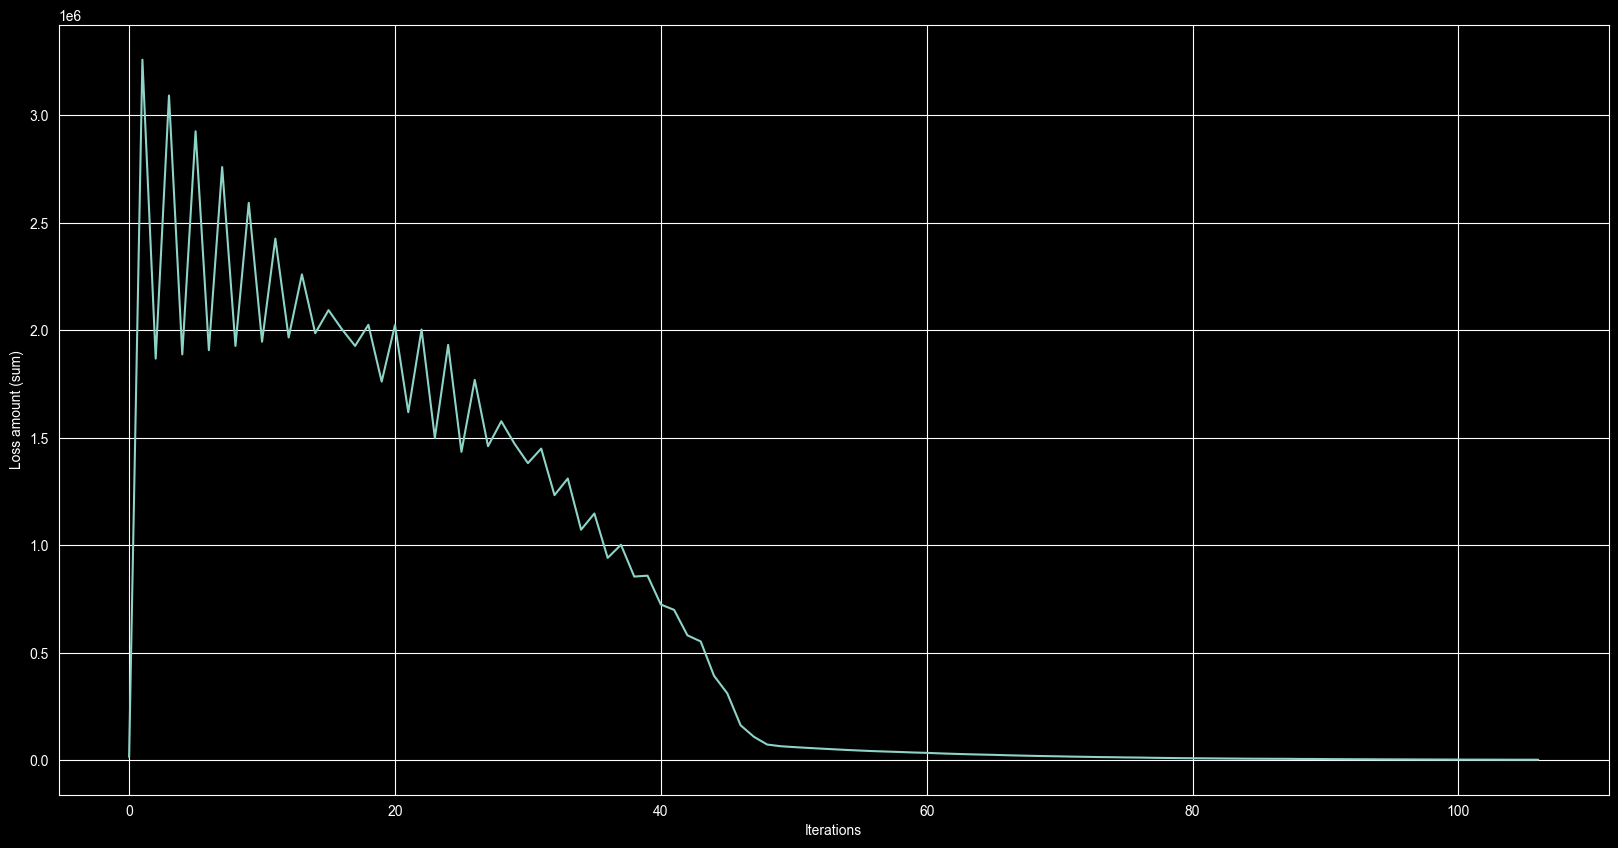

In [121]:
show_plot(model.loss, "Iterations", "Loss amount (sum)")

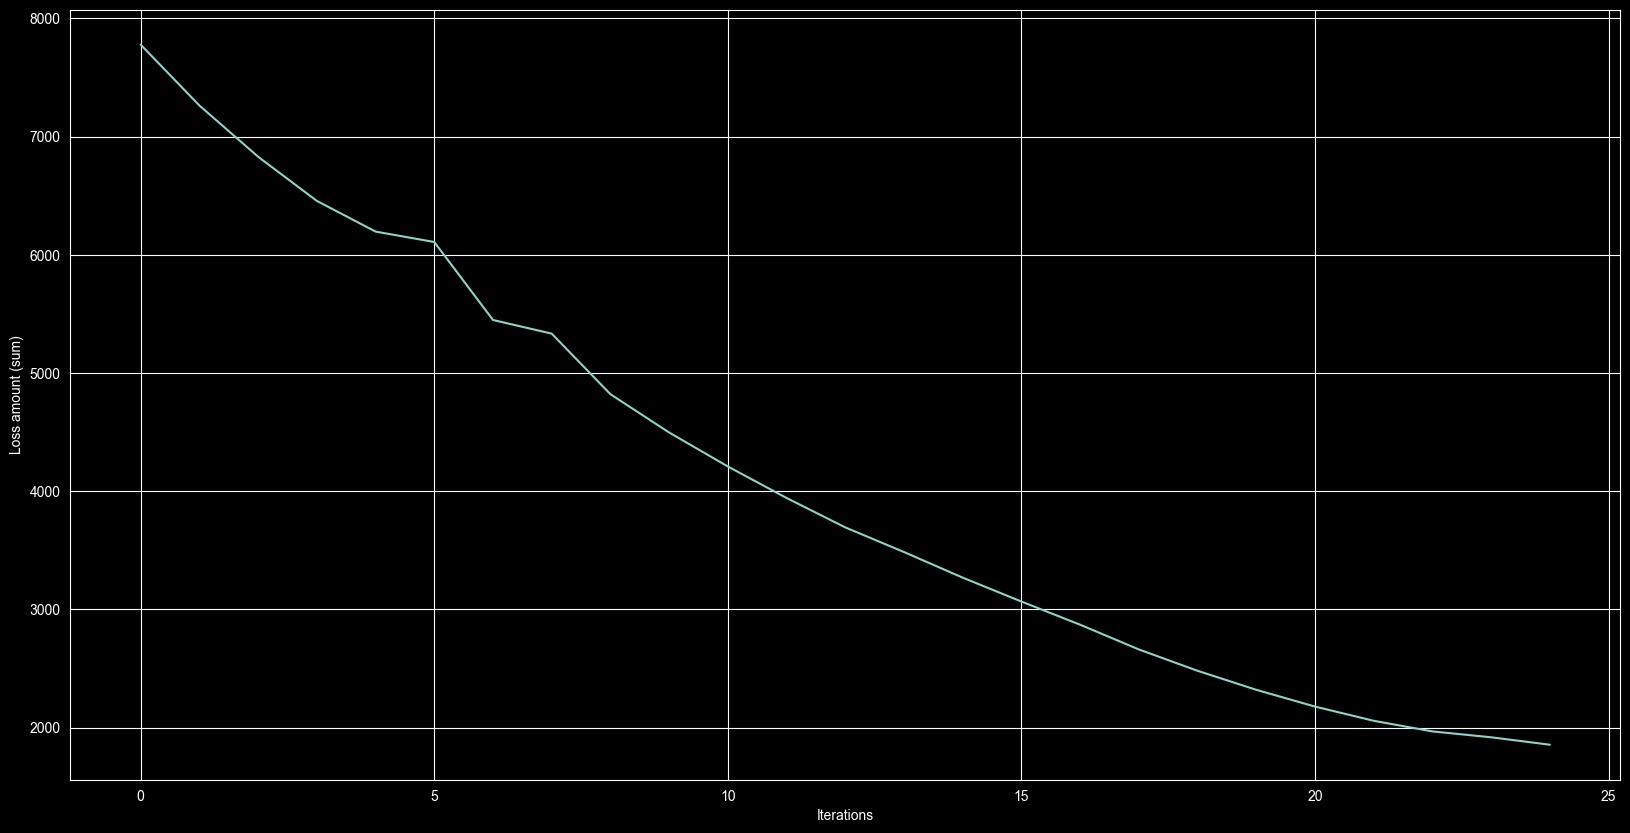

In [122]:
show_plot(model.loss[-25:], "Iterations", "Loss amount (sum)")

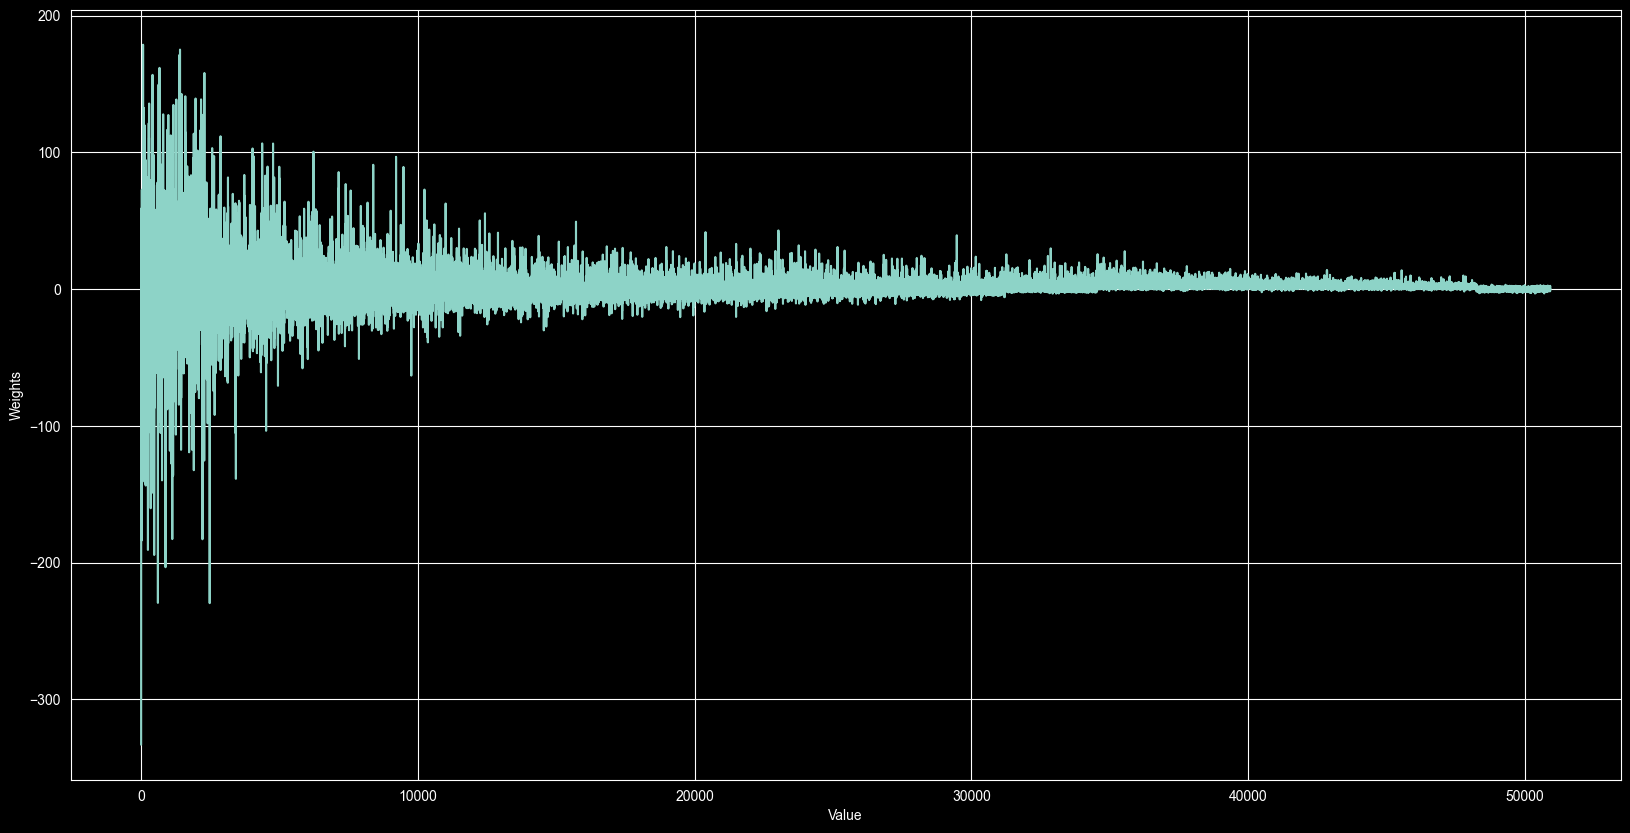

In [123]:
show_plot(model.param_vector[1:], "Value", "Weights")

In [124]:
assert len(model.param_vector[1:]) == len(ordered_vocabulary)

In [125]:
idx = np.argsort(np.abs(model.param_vector[1:]))

print("                Word   Weight  Occurences")
for i in idx[-20:]:   # Pick those with highest 'voting' values
    print("%20s   %.3f\t%i " % (ordered_vocabulary[i], model.param_vector[i+1], np.sum([ordered_vocabulary[i] in d for d in X_train])))

                Word   Weight  Occurences
               awful   -143.625	130 
               least   -148.879	407 
        performances   149.498	290 
                life   156.631	707 
           hilarious   157.990	163 
               looks   -160.210	301 
                very   161.739	1247 
              stupid   -166.367	181 
                best   171.190	693 
                both   175.092	544 
                also   178.655	850 
            supposed   -182.754	246 
       unfortunately   -182.874	271 
                   ?   -183.678	990 
             nothing   -190.680	479 
              boring   -194.377	184 
              script   -203.319	511 
                plot   -229.393	806 
               worst   -229.585	199 
                 bad   -333.083	668 


# Part 4: Exploring hyperparameters

In [126]:
# Define the parameters
n_samples = 10
best_hparam = None

In [127]:
print("Learning rate:\tReg.dampening:\tTraining set accuracy:")
for a, b in zip(np.random.choice(np.logspace(-4, 3, num=1000), n_samples), np.random.choice(np.logspace(-4, 3, num=1000), n_samples)):

  # Set up the classifier
  model = Classifier(ordered_vocabulary, regularizer_dampening=a, learning_rate=b)

  # Train the classifier
  model.fit(X_train_bow, y_train)

  # Calculate the training accuracy
  train_accuracy = np.sum(model.predict(X_train_bow) == y_train) / len(y_train)

  # Store the hyperparameters if they are better than what we have found before
  if best_hparam is None or best_hparam[2] < train_accuracy:
    best_hparam = (a, b, train_accuracy)
  print("%.3f\t\t%.3f\t\t%.1f%%" % (a, b, 100 * train_accuracy))

best_a = best_hparam[0]
best_b = best_hparam[1]
print("Best parameters: %.5f, %.5f" % (best_a, best_b))

Learning rate:	Reg.dampening:	Training set accuracy:
0.867		14.130		99.8%
0.004		0.006		95.6%
106.176		0.142		50.0%
0.267		0.055		99.9%
0.210		50.548		100.0%
0.002		22.928		100.0%
0.012		7.531		100.0%
12.025		516.075		65.0%
333.829		0.008		50.0%
0.000		922.497		100.0%
Best parameters: 0.20957, 50.54797


In [128]:
# Set up the classifier
model = Classifier(ordered_vocabulary, regularizer_dampening=best_a, learning_rate=best_b)

# Train on all the non-test data
model.fit(X_train_bow, y_train)

# Run prediction on the test set
test_accuracy = np.sum(model.predict(X_test_bow)==y_test)/len(y_test)

print("Test set accuracy %.1f%%" % (100*test_accuracy))

Test set accuracy 85.2%


# Report

TO DO

# Part: VG

In [ ]:
class Vectorizer_but_better(Vectorizer):

    def tf_idf(self):
        pass

    # takes a list of texts and returns its corresponding bag-of-words vector, according to the vocabulary
    def transform_to_bow(self, data_list):
        matrix_size = (len(data_list), len(self.vocabulary))
        X = np.zeros(matrix_size)
        for i, txt in enumerate(data_list):
            for token in self.tokenize(txt):
                X[i, self.vocabulary.index(token)] = 1
        return X

In [ ]:
class SGDClassifier(Classifier):

    def _gradient(self, X, y):
        v1 = np.multiply(y, self._score(X))
        index = v1 < 1 # condition
        v = np.zeros(X.shape)
        v[index] = -y[index].reshape((-1,1)) * X[index] # reshape so multiplication works
        return self.lambduh * np.sign(self.param_vector) + np.sum(v, axis=0) # sum on row axis, not colum

# PLEASE FAIL ME, I WANT THE VG GRADE BUT DID NOT FINISH IN TIME (obviously)